**Modelo de red neuronal SVR**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Series de tiempo
* 3.Normalizar Datos.
* 4.Preparar datos para realizar aprendizaje supervizado.
* 5.Modelo SVR
* 6.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [33]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

# import the model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time
import joblib

In [34]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [35]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [36]:
df=pd.read_csv('df_EDA.csv',
                parse_dates={'dt':['Date','time']},
                infer_datetime_format=True,
                low_memory=False,
                index_col='dt')

In [37]:
df=df[['Global_active_power','Global_intensity', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2053263 entries, 2007-01-01 00:00:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_intensity       float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.3 MB


In [39]:
df.shape

(2053263, 7)

In [40]:
## resampling of data over hour
df = df.resample('D').mean()
df.shape

(1426, 7)

In [41]:
#Setear semilla
np.random.seed(42)

#2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [42]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

df.head()

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,2.034827,1.981839,-0.579222,-0.344607,-1.006100,-0.715621,-0.877707
2007-01-02,-0.479665,-0.505030,0.254588,0.541014,-1.006100,-0.717544,-0.698740
2007-01-03,-0.913282,-0.919220,0.380838,1.328309,-1.006100,-0.719467,-1.170300
2007-01-04,2.902136,2.905632,0.491035,-0.529403,-0.344237,2.768191,0.438568
2007-01-05,1.974266,1.963020,-0.085215,-0.165616,-0.072187,-0.702637,-0.425828


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [43]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [44]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [45]:
serie_df = pd.concat(serie_split, axis=1).dropna()
serie_df.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_active_power(t+1),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_intensity(t+1),Global_reactive_power(t-2),Global_reactive_power(t-1),...,Sub_metering_1(t-0),Sub_metering_1(t+1),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_2(t+1),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),Sub_metering_3(t+1)
dt,,,,,,,,,,,,,,,,,,,,,
2007-01-04,2.034827,-0.479665,-0.913282,2.902136,1.981839,-0.505030,-0.919220,2.905632,-0.579222,0.254588,...,-1.006100,-0.344237,-0.715621,-0.717544,-0.719467,2.768191,-0.877707,-0.698740,-1.170300,0.438568
2007-01-05,-0.479665,-0.913282,2.902136,1.974266,-0.505030,-0.919220,2.905632,1.963020,0.254588,0.380838,...,-0.344237,-0.072187,-0.717544,-0.719467,2.768191,-0.702637,-0.698740,-1.170300,0.438568,-0.425828
2007-01-06,-0.913282,2.902136,1.974266,-0.073304,-0.919220,2.905632,1.963020,-0.014000,0.380838,0.491035,...,-0.072187,-0.164759,-0.719467,2.768191,-0.702637,-0.691578,-1.170300,0.438568,-0.425828,-0.930715
2007-01-07,2.902136,1.974266,-0.073304,1.522701,2.905632,1.963020,-0.014000,1.606520,0.491035,-0.085215,...,-0.164759,0.245206,2.768191,-0.702637,-0.691578,3.047088,0.438568,-0.425828,-0.930715,0.940831
2007-01-08,1.974266,-0.073304,1.522701,1.172214,1.963020,-0.014000,1.606520,1.174003,-0.085215,0.291083,...,0.245206,-1.006100,-0.702637,-0.691578,3.047088,-0.660322,-0.425828,-0.930715,0.940831,2.183893


In [46]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [47]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [48]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Voltage(t-0),Sub_metering_1(t-2),Sub_metering_1(t-1),Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2007-01-04,2.034827,-0.479665,-0.913282,1.981839,-0.505030,-0.919220,-0.579222,0.254588,0.380838,-0.344607,...,1.328309,-1.006100,-1.006100,-1.006100,-0.715621,-0.717544,-0.719467,-0.877707,-0.698740,-1.170300
2007-01-05,-0.479665,-0.913282,2.902136,-0.505030,-0.919220,2.905632,0.254588,0.380838,0.491035,0.541014,...,-0.529403,-1.006100,-1.006100,-0.344237,-0.717544,-0.719467,2.768191,-0.698740,-1.170300,0.438568
2007-01-06,-0.913282,2.902136,1.974266,-0.919220,2.905632,1.963020,0.380838,0.491035,-0.085215,1.328309,...,-0.165616,-1.006100,-0.344237,-0.072187,-0.719467,2.768191,-0.702637,-1.170300,0.438568,-0.425828
2007-01-07,2.902136,1.974266,-0.073304,2.905632,1.963020,-0.014000,0.491035,-0.085215,0.291083,-0.529403,...,-0.567097,-0.344237,-0.072187,-0.164759,2.768191,-0.702637,-0.691578,0.438568,-0.425828,-0.930715
2007-01-08,1.974266,-0.073304,1.522701,1.963020,-0.014000,1.606520,-0.085215,0.291083,1.356397,-0.165616,...,0.032864,-0.072187,-0.164759,0.245206,-0.702637,-0.691578,3.047088,-0.425828,-0.930715,0.940831


In [49]:
target_variables.head()

,Global_active_power(t+1)
dt,
2007-01-04,2.902136
2007-01-05,1.974266
2007-01-06,-0.073304
2007-01-07,1.522701
2007-01-08,1.172214


In [50]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [65]:
X_train.shape

(1138, 21)

#5.SVR

In [52]:
# Definir la función objetivo
def objective(params):

    # Definir los hiperparámetros a optimizar
    kernel = params['kernel']
    gamma = params['gamma']
    C = float(params['C'])
    epsilon  = float(params['epsilon'])

    tscv = TimeSeriesSplit(n_splits=5)

    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_, y_test_ = Y_train.iloc[train_index], Y_train.iloc[test_index]

      model_SVR = SVR(kernel = kernel, gamma =gamma, C =C, epsilon =epsilon )

      #Entrenamiento
      start = time.time()
      model_SVR.fit(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model_SVR.predict(X_test)
      score_mse = mse(Y_test, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test, y_pred)
      score_mape= mape(Y_test, y_pred)


      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model_SVR,
            'params': params,
            'time':times,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse
            }

In [53]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'kernel':hp.choice('kernel',['poly', 'rbf', 'sigmoid', 'linear']),
    'gamma': hp.choice('gamma', ['scale', 'auto'],),
    'C': hp.uniform('C', 0.1, 1),
    'epsilon': hp.uniform('epsilon', 0.1, 0.9),
}

In [54]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Los mejores hiperparámetros son: ", best)

100%|██████████| 100/100 [00:17<00:00,  5.64trial/s, best loss: 0.34840885827537255]
Los mejores hiperparámetros son:  {'C': 0.8772346347728702, 'epsilon': 0.5398462768583149, 'gamma': 0, 'kernel': 1}


In [55]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
best_model = best_trial['result']['model']

In [56]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [57]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'C': 0.8772346347728702,
 'epsilon': 0.5398462768583149,
 'gamma': 'scale',
 'kernel': 'rbf'}

In [58]:
#Se realiza prediccion
results = best_model.predict(X_test)

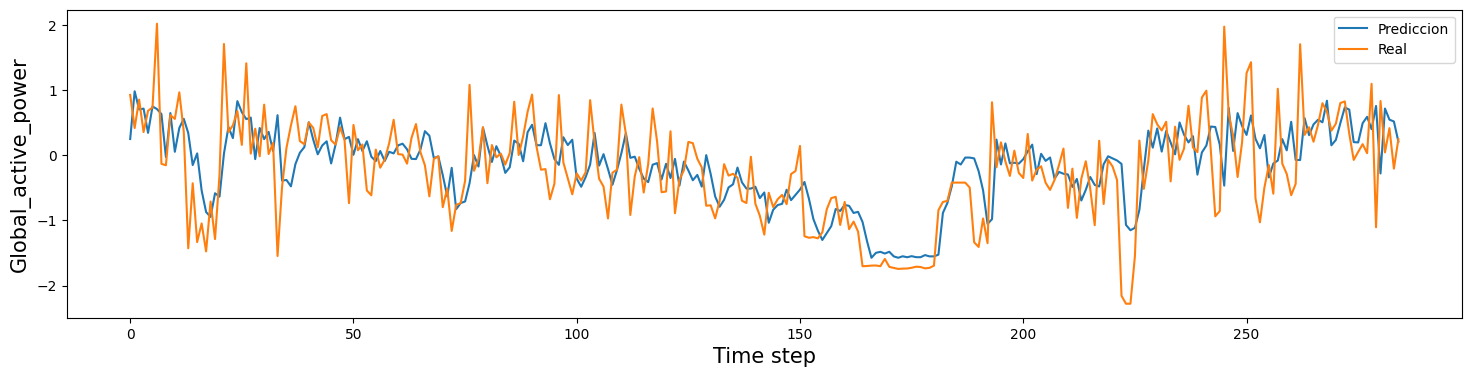

In [59]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [60]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "SVR" + "_"+str(result['params']['kernel'])+"_"+str(result['params']['C'])+"_"+str(result['params']['epsilon'])+"_"+str(result['params']['gamma'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [61]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
354,SVR_rbf_0.8772346347728702_0.5398462768583149_...,71,5,0.035124,0.348409,1.714970,0.590262,0.433681
344,SVR_rbf_0.8913495971886025_0.5341145467857797_...,69,5,0.035171,0.348436,1.714580,0.590285,0.433701
374,SVR_rbf_0.7974364176322617_0.5544894024977772_...,75,5,0.033814,0.348619,1.732445,0.590440,0.433526
369,SVR_rbf_0.8157675897302965_0.5433572936467199_...,74,5,0.034230,0.348690,1.722422,0.590500,0.433344
464,SVR_rbf_0.7612560431507306_0.5693187506697562_...,93,5,0.031291,0.349585,1.759451,0.591257,0.434633


In [62]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_SVR_CE.csv')

In [63]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_SVR'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [64]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0

  nameModel = "SVR" + "_"+str(result['params']['kernel'])+"_"+str(result['params']['C'])+"_"+str(result['params']['epsilon'])+"_"+str(result['params']['gamma'])
  ruta = os.path.join(carpeta_destino, nameModel + ".pkl")
  joblib.dump(result['model'], ruta)
